<a href="https://colab.research.google.com/github/simple3957/CreditRiskAnalyzer/blob/main/cra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn xgboost shap


In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score


In [3]:
# Load datasets
train_path = "/content/train.csv"
test_path = "/content/test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Drop unnecessary columns
drop_cols = ["ID", "Customer_ID", "SSN", "Name", "Month"]
train_df.drop(columns=drop_cols, inplace=True)
test_df.drop(columns=drop_cols, inplace=True)

# Check dataset info
print(train_df.info())


<ipython-input-3-991a8598f1e0>:5: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(train_path)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Age                       100000 non-null  object 
 1   Occupation                100000 non-null  object 
 2   Annual_Income             100000 non-null  object 
 3   Monthly_Inhand_Salary     84998 non-null   float64
 4   Num_Bank_Accounts         100000 non-null  int64  
 5   Num_Credit_Card           100000 non-null  int64  
 6   Interest_Rate             100000 non-null  int64  
 7   Num_of_Loan               100000 non-null  object 
 8   Type_of_Loan              88592 non-null   object 
 9   Delay_from_due_date       100000 non-null  int64  
 10  Num_of_Delayed_Payment    92998 non-null   object 
 11  Changed_Credit_Limit      100000 non-null  object 
 12  Num_Credit_Inquiries      98035 non-null   float64
 13  Credit_Mix                100000 non-null  ob

In [4]:
# Fill missing numerical values with median
num_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
train_df[num_cols] = train_df[num_cols].fillna(train_df[num_cols].median())

# Fill missing categorical values with mode
cat_cols = train_df.select_dtypes(include=['object']).columns
train_df[cat_cols] = train_df[cat_cols].fillna(train_df[cat_cols].mode().iloc[0])

# Convert appropriate columns to numeric
num_convert = ["Annual_Income", "Outstanding_Debt", "Amount_invested_monthly", "Changed_Credit_Limit", "Num_of_Loan"]
for col in num_convert:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')


In [5]:
# Encode Credit Score (Target Variable)
label_map = {"Poor": 0, "Standard": 1, "Good": 2}
train_df["Credit_Score"] = train_df["Credit_Score"].map(label_map)

# One-hot encode categorical features
cat_cols = ["Occupation", "Credit_Mix", "Payment_of_Min_Amount", "Payment_Behaviour"]
train_df = pd.get_dummies(train_df, columns=cat_cols, drop_first=True)

print(train_df.head())


    Age  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0    23       19114.12            1824.843333                  3   
1    23       19114.12            3093.745000                  3   
2  -500       19114.12            3093.745000                  3   
3    23       19114.12            3093.745000                  3   
4    23       19114.12            1824.843333                  3   

   Num_Credit_Card  Interest_Rate  Num_of_Loan  \
0                4              3          4.0   
1                4              3          4.0   
2                4              3          4.0   
3                4              3          4.0   
4                4              3          4.0   

                                        Type_of_Loan  Delay_from_due_date  \
0  Auto Loan, Credit-Builder Loan, Personal Loan,...                    3   
1  Auto Loan, Credit-Builder Loan, Personal Loan,...                   -1   
2  Auto Loan, Credit-Builder Loan, Personal Loan,...       

In [6]:
scaler = StandardScaler()
num_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
num_cols = num_cols.drop("Credit_Score")  # Exclude target variable

train_df[num_cols] = scaler.fit_transform(train_df[num_cols])


In [7]:
# Convert numerical columns stored as object to float
num_convert = ["Age", "Num_of_Delayed_Payment", "Credit_History_Age", "Monthly_Balance"]
for col in num_convert:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')

# Handle 'Type_of_Loan' by encoding or one-hot encoding
train_df["Type_of_Loan"] = train_df["Type_of_Loan"].astype(str).apply(lambda x: x.replace(" and ", ", "))
train_df = train_df.drop(columns=["Type_of_Loan"])  # Drop for now (complex categorical)

# Verify all columns are numeric
print(train_df.dtypes)


Age                                                   float64
Annual_Income                                         float64
Monthly_Inhand_Salary                                 float64
Num_Bank_Accounts                                     float64
Num_Credit_Card                                       float64
Interest_Rate                                         float64
Num_of_Loan                                           float64
Delay_from_due_date                                   float64
Num_of_Delayed_Payment                                float64
Changed_Credit_Limit                                  float64
Num_Credit_Inquiries                                  float64
Outstanding_Debt                                      float64
Credit_Utilization_Ratio                              float64
Credit_History_Age                                    float64
Total_EMI_per_month                                   float64
Amount_invested_monthly                               float64
Monthly_

In [8]:
X = train_df.drop(columns=["Credit_Score"])
y = train_df["Credit_Score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [9]:
from sklearn.impute import SimpleImputer

# Identify fully missing columns
fully_missing_cols = X_train.columns[X_train.isnull().all()]
print("Dropping fully missing columns:", fully_missing_cols.tolist())

# Drop fully missing columns
X_train = X_train.drop(columns=fully_missing_cols)

# Convert categorical features to numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')

# Define imputer to fill missing values
imputer = SimpleImputer(strategy="median")

# Apply imputer
X_train_imputed = imputer.fit_transform(X_train)

# Convert back to DataFrame with correct column names
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)

# Apply SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_imputed, y_train)

print("SMOTE applied successfully! New shape:", X_train_resampled.shape)


Dropping fully missing columns: ['Credit_History_Age']
SMOTE applied successfully! New shape: (127617, 42)


In [10]:

from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Define parameter grid
params = {
    "max_depth": [4, 6],  # Reduce options
    "learning_rate": [0.01, 0.1],  # Reduce options
    "n_estimators": [100],  # Fix to one value
    "subsample": [0.8, 1.0],
}



# RandomizedSearchCV (trains fewer models)
random_search = RandomizedSearchCV(
    xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="mlogloss"),
    param_distributions=params,
    n_iter=10,  # Try only 10 random combinations
    scoring="accuracy",
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit the model
random_search.fit(X_train_imputed, y_train)

# Best parameters
best_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:37:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1}


In [11]:
missing_cols = set(X_train.columns) - set(X_test.columns)
extra_cols = set(X_test.columns) - set(X_train.columns)

print("Missing in X_test:", missing_cols)
print("Extra in X_test:", extra_cols)

Missing in X_test: set()
Extra in X_test: {'Credit_History_Age'}


In [12]:
# Drop extra columns that are in X_test but not in X_train
X_test = X_test.drop(columns=extra_cols, errors="ignore")

# Add missing columns with default values (0)
for col in missing_cols:
    X_test[col] = 0  # Assign a default value (or use median if known)

# Ensure column order matches
X_test = X_test[X_train.columns]

print("Final X_test shape:", X_test.shape)


Final X_test shape: (20000, 42)


In [13]:
model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

# Model Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob, multi_class="ovr"))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.71395
ROC-AUC Score: 0.8624735432781373
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.65      0.70      5799
           1       0.74      0.77      0.75     10635
           2       0.59      0.66      0.63      3566

    accuracy                           0.71     20000
   macro avg       0.69      0.69      0.69     20000
weighted avg       0.72      0.71      0.71     20000



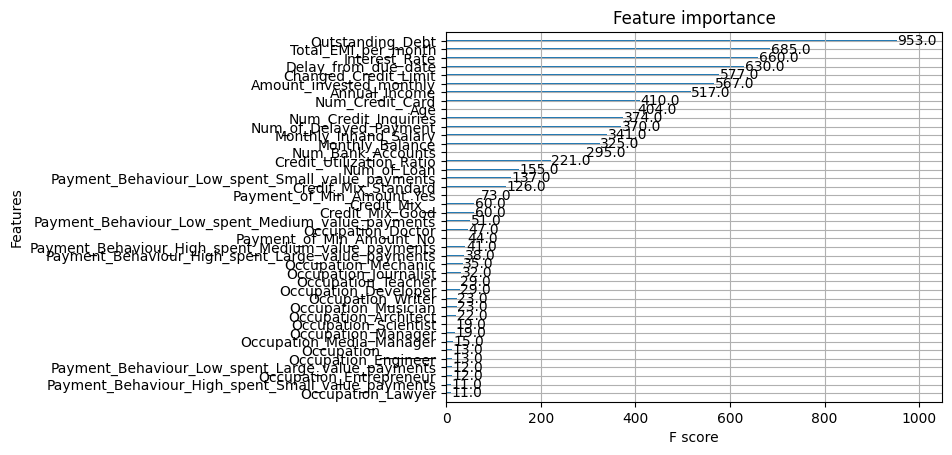

In [14]:
xgb.plot_importance(model)
plt.show()


In [21]:
# ✅ Import necessary libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

# ✅ Load dataset
train_path = "/content/train.csv"
test_path = "/content/test.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# ✅ Drop Unnecessary Columns (ID or duplicate features)
drop_cols = ['ID']  # Add any extra columns if not needed
df_train.drop(columns=[col for col in drop_cols if col in df_train.columns], inplace=True)
df_test.drop(columns=[col for col in drop_cols if col in df_test.columns], inplace=True)

# ✅ Handle Missing Values
# ---->  Impute numerical features first with median
num_cols = df_train.select_dtypes(include=np.number).columns
df_train[num_cols] = df_train[num_cols].fillna(df_train[num_cols].median())
df_test[num_cols] = df_test[num_cols].fillna(df_test[num_cols].median())

# ----> Convert columns to numeric where possible before calculating the mode for categorical features
for col in df_train.select_dtypes(include=['object']).columns:
    try:
        df_train[col] = pd.to_numeric(df_train[col], errors='raise')
    except ValueError:
        pass  # Skip columns that cannot be converted to numeric
# ----> Convert columns to numeric where possible before calculating the mode for categorical features
for col in df_test.select_dtypes(include=['object']).columns:
    try:
        df_test[col] = pd.to_numeric(df_test[col], errors='raise')
    except ValueError:
        pass  # Skip columns that cannot be converted to numeric

# ----> Impute categorical features with mode
cat_cols = df_train.select_dtypes(exclude=np.number).columns
for col in cat_cols:
    df_train[col] = df_train[col].fillna(df_train[col].mode()[0])
    df_test[col] = df_test[col].fillna(df_test[col].mode()[0])


# ✅ Convert Categorical Features (One-Hot Encoding)
cat_cols = df_train.select_dtypes(include=['object']).columns.tolist()
df_train = pd.get_dummies(df_train, columns=cat_cols, drop_first=True)
df_test = pd.get_dummies(df_test, columns=cat_cols, drop_first=True)

# ✅ Ensure Same Features in Train & Test
missing_cols = set(df_train.columns) - set(df_test.columns)
for col in missing_cols:
    df_test[col] = 0  # Add missing columns with default values

df_test = df_test[df_train.columns]  # Ensure same column order

# ✅ Feature Engineering (Create New Features)
df_train["Debt_to_Income_Ratio"] = df_train["Outstanding_Debt"] / (df_train["Annual_Income"] + 1)
df_test["Debt_to_Income_Ratio"] = df_test["Outstanding_Debt"] / (df_test["Annual_Income"] + 1)

df_train["Credit_Limit_Change"] = df_train["Changed_Credit_Limit"] / (df_train["Num_of_Credit_Card"] + 1)
df_test["Credit_Limit_Change"] = df_test["Changed_Credit_Limit"] / (df_test["Num_of_Credit_Card"] + 1)

# ✅ Split Features & Labels
X = df_train.drop(columns=["Credit_Score"])  # Change target column if needed
y = df_train["Credit_Score"]

# ✅ Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ✅ Handle Class Imbalance (Apply SMOTE)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# ✅ Scale Features (Normalization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(df_test)

# ✅ Define XGBoost Model with Hyperparameter Tuning
xgb_model = xgb.XGBClassifier(objective="multi:softmax", num_class=3, random_state=42)

param_grid = {
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 200],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

grid_search = RandomizedSearchCV(xgb_model, param_grid, scoring="accuracy", cv=3, n_jobs=-1, verbose=2, n_iter=10, random_state=42)
grid_search.fit(X_train_scaled, y_train_smote)

best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# ✅ Predictions & Evaluation
y_pred = best_model.predict(X_val_scaled)
y_prob = best_model.predict_proba(X_val_scaled)

accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_prob, multi_class="ovr")

print(f"Accuracy: {accuracy:.5f}")
print(f"ROC-AUC Score: {roc_auc}")
print("Classification Report:\n", classification_report(y_val, y_pred))

# ✅ Predict on Test Data
y_test_pred = best_model.predict(X_test_scaled)
df_test["Predicted_Credit_Score"] = y_test_pred

# ✅ Save Predictions
df_test.to_csv("credit_score_predictions.csv", index=False)
print("Predictions saved successfully! 🚀")

<ipython-input-21-5321e7b83271>:18: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(train_path)


KeyError: 'Credit_Score'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [ ]:
# Load Datasets

# Define file paths
train_file_path = '/content/train.csv'
test_file_path = '/content/test.csv'

# Load the datasets using pandas
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# Display the first few rows of the train and test datasets
print("Train Dataset:")
print(train_df.head())

print("\nTest Dataset:")
print(test_df.head())

In [ ]:
# Exploratory Data Analysis (EDA)

# Display basic information about the datasets
print("Train Dataset Info:")
print(train_df.info())

print("\nTest Dataset Info:")
print(test_df.info())

# Summary statistics of the train dataset
print("\nTrain Dataset Summary Statistics:")
print(train_df.describe())

# Summary statistics of the test dataset
print("\nTest Dataset Summary Statistics:")
print(test_df.describe())

# Check for missing values in the train dataset
print("\nMissing Values in Train Dataset:")
print(train_df.isnull().sum())

# Check for missing values in the test dataset
print("\nMissing Values in Test Dataset:")
print(test_df.isnull().sum())

# Visualize the distribution of numerical features in the train dataset
train_df.hist(bins=30, figsize=(20, 15), color='skyblue', edgecolor='black')
plt.suptitle('Distribution of Numerical Features in Train Dataset')
plt.show()

# Visualize the correlation matrix of the train dataset
plt.figure(figsize=(12, 8))

# Select only numerical features for correlation calculation
numerical_features = train_df.select_dtypes(include=[np.number]).columns
correlation_matrix = train_df[numerical_features].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Train Dataset')
plt.show()

# Visualize the relationship between numerical features and the target variable
if 'target' in train_df.columns:
    numerical_features = train_df.select_dtypes(include=[np.number]).columns.tolist()
    numerical_features.remove('target')
    for feature in numerical_features:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='target', y=feature, data=train_df, palette='viridis')
        plt.title(f'Relationship between {feature} and Target Variable')
        plt.xlabel('Target')
        plt.ylabel(feature)
        plt.show()

In [ ]:
# Data Cleaning

# Handle missing values by filling with the median for numerical features and mode for categorical features
for column in train_df.columns:
    if train_df[column].dtype == 'object':
        train_df[column].fillna(train_df[column].mode()[0], inplace=True)
    else:
        train_df[column].fillna(train_df[column].median(), inplace=True)

for column in test_df.columns:
    if test_df[column].dtype == 'object':
        test_df[column].fillna(test_df[column].mode()[0], inplace=True)
    else:
        test_df[column].fillna(test_df[column].median(), inplace=True)

# Remove duplicates from the datasets
train_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)

# Correct data types if necessary (example: converting categorical columns to 'category' dtype)
for column in train_df.select_dtypes(include=['object']).columns:
    train_df[column] = train_df[column].astype('category')

for column in test_df.select_dtypes(include=['object']).columns:
    test_df[column] = test_df[column].astype('category')

# Display the cleaned datasets
print("Cleaned Train Dataset:")
print(train_df.head())

print("\nCleaned Test Dataset:")
print(test_df.head())

# Display basic information about the cleaned datasets
print("Cleaned Train Dataset Info:")
print(train_df.info())

print("\nCleaned Test Dataset Info:")
print(test_df.info())

In [ ]:
# Data Preprocessing

# Encode categorical variables using one-hot encoding
train_df = pd.get_dummies(train_df, drop_first=True)
test_df = pd.get_dummies(test_df, drop_first=True)

# Align the train and test datasets to ensure they have the same columns
train_df, test_df = train_df.align(test_df, join='inner', axis=1)

# Separate features and target variable from the train dataset
X = train_df.drop('target', axis=1)
y = train_df['target']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Display the shapes of the resampled training data
print("Resampled Training Data Shape:", X_train_resampled.shape)
print("Resampled Training Target Shape:", y_train_resampled.shape)